In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
import itertools

In [3]:
from ast import literal_eval

### Linear probes eval

In [4]:
resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsp:
    for depth in range(1,5):
        folder_name = "../linprob_sweep/logs/" + key + '/vit_base_patch16/lin_' + str(depth) +'/'

        for root, dirs, files in os.walk(folder_name):
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)      
            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file): 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        resultsp[key][depth] = df

../linprob_sweep/logs/MAE/vit_base_patch16/lin_1/26795/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_2/26796/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_3/26797/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_4/26798/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_1/26872/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_2/26873/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_3/26874/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_4/26875/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_1/26895/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_2/26896/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_3/26897/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_4/26898/log.txt


In [5]:
df= {}
for key in resultsp:
    df[key] = {}
    for depth in range(1,5):
        df[key][depth] = {}
        df[key][depth] = resultsp[key][depth]['test_acc1'].max()

In [6]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe Depth'}, inplace=True)
df = df.melt(id_vars=['Probe Depth'], value_name='Top-1', var_name='Model')

In [7]:
df

,Probe Depth,Model,Top-1
0,1,MAE,67.696
1,2,MAE,68.138
2,3,MAE,68.728
3,4,MAE,68.432
4,1,MoCo,76.242
5,2,MoCo,76.086
6,3,MoCo,75.836
7,4,MoCo,75.584
8,1,DINO,77.822
9,2,DINO,77.742


In [8]:
fig_dir = '../figures/ICML/'

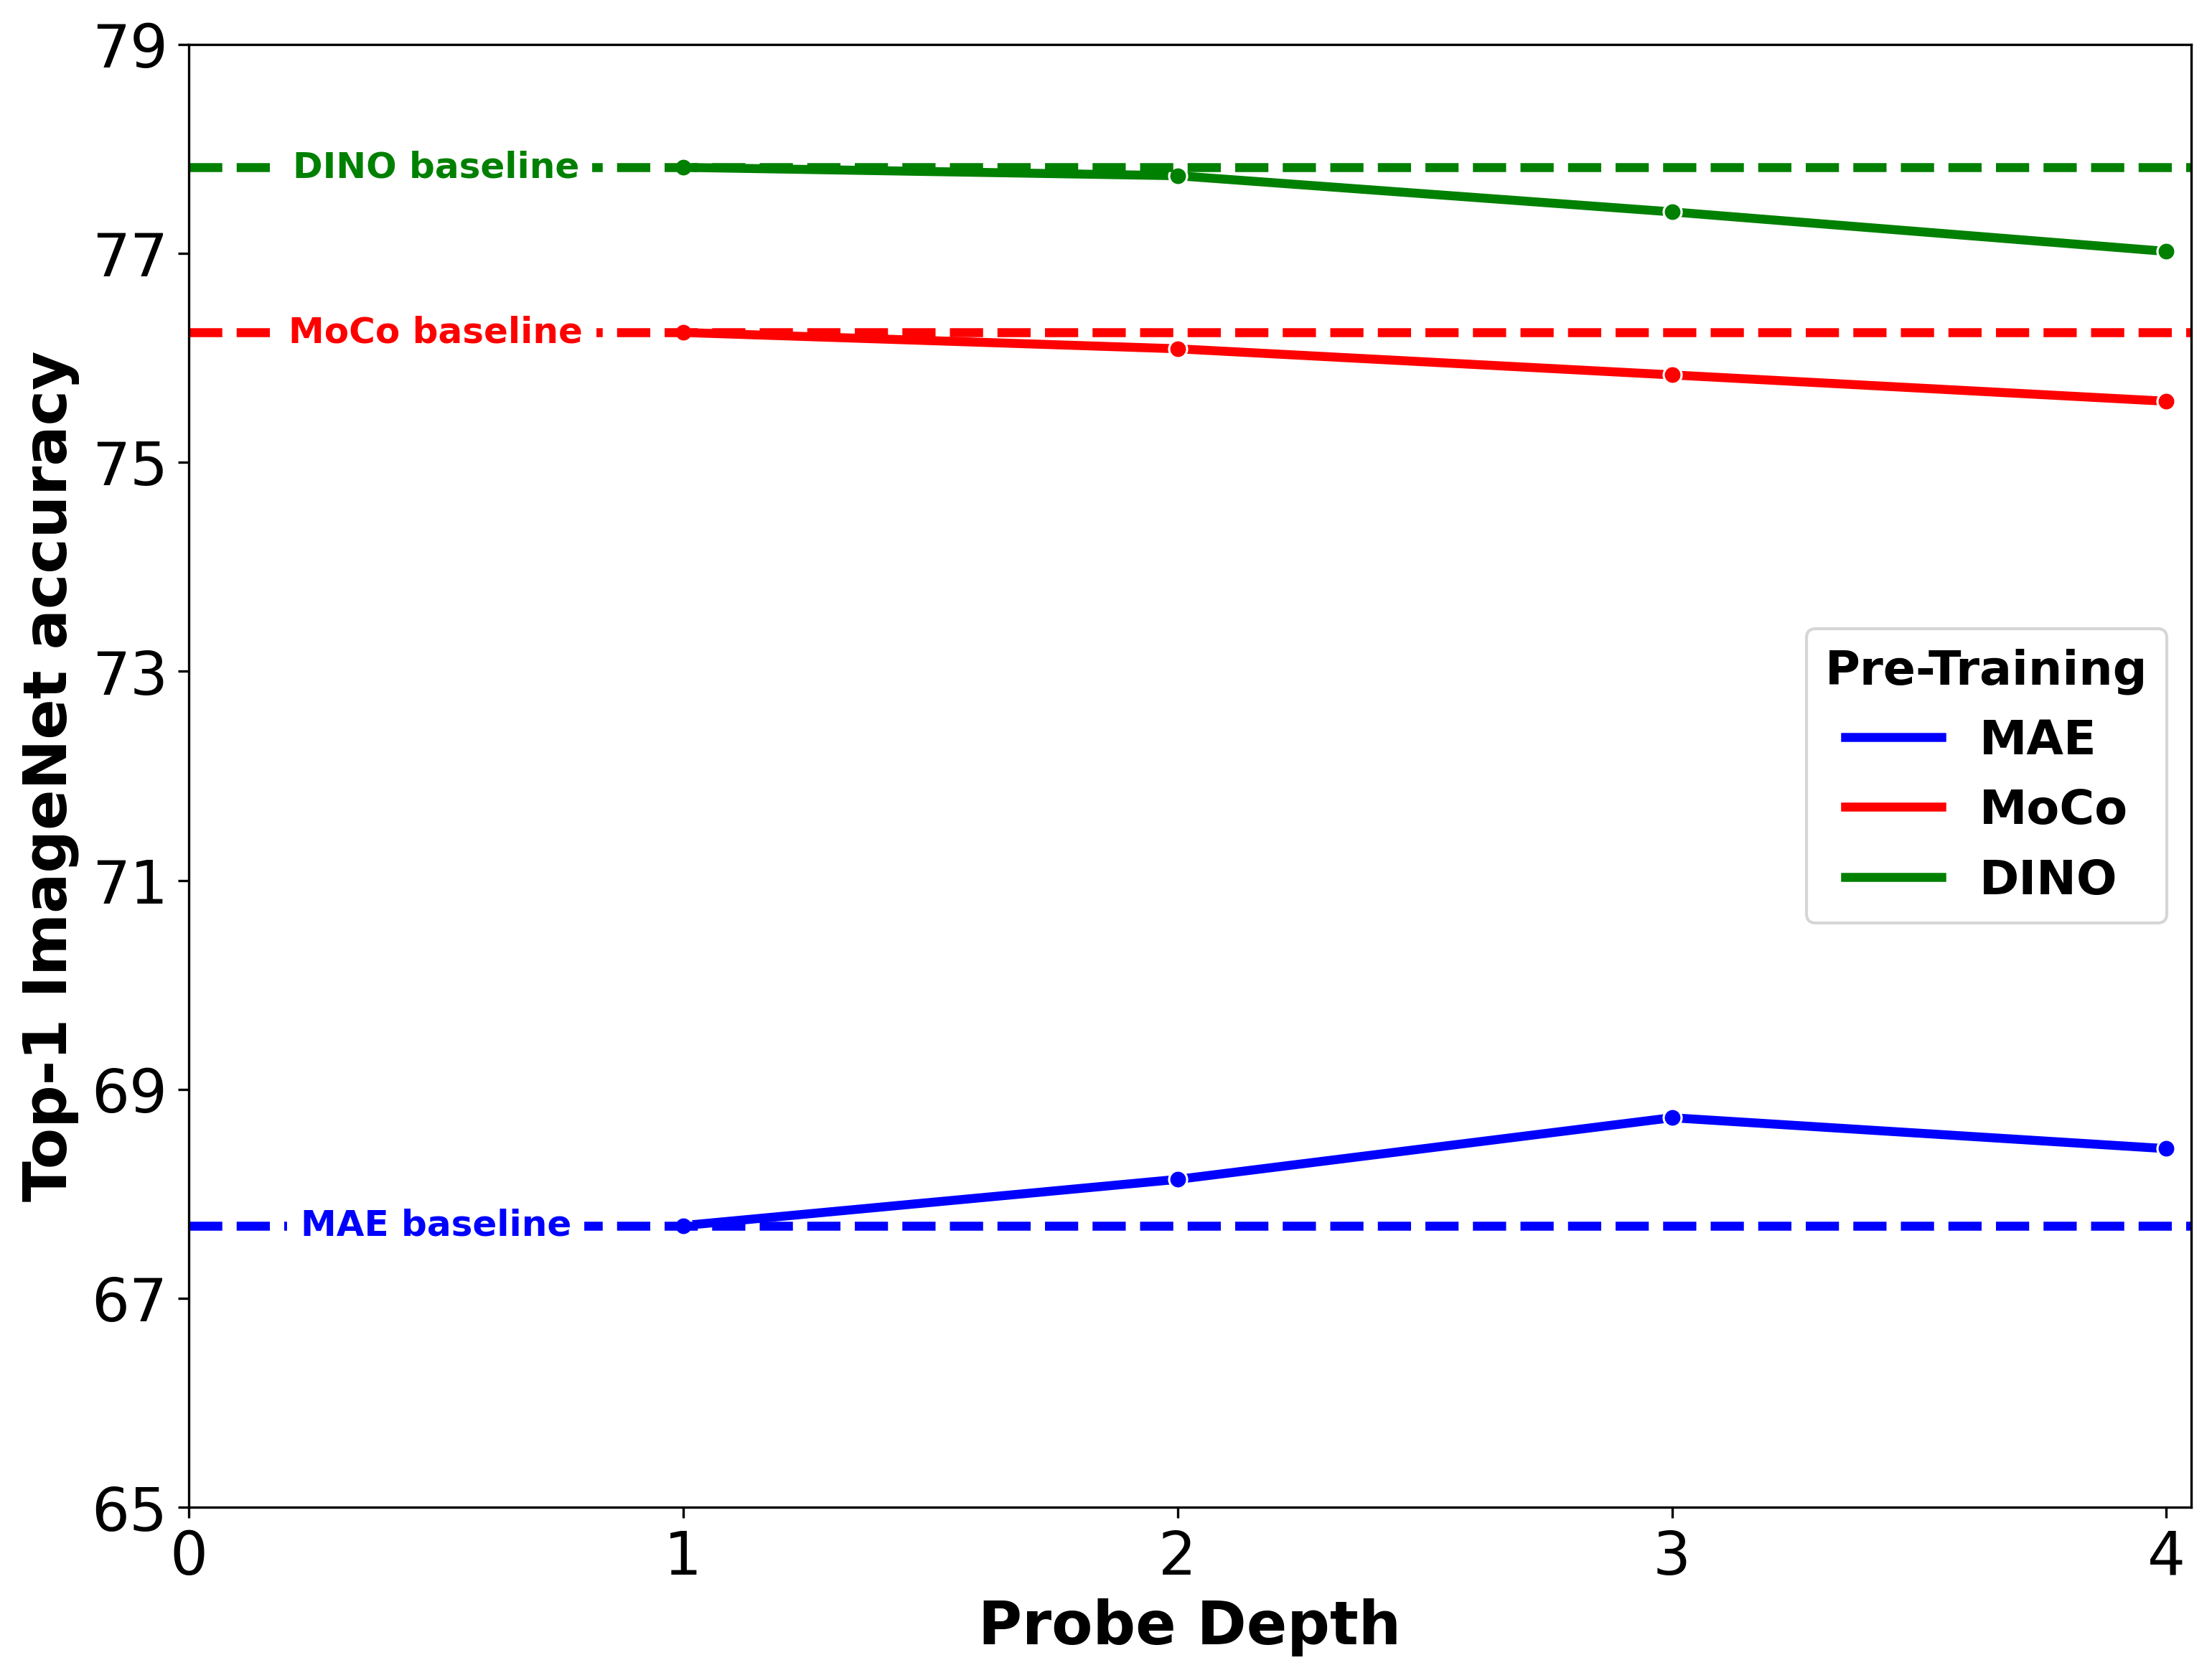

In [9]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

sns.lineplot(data=df, x='Probe Depth', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')

ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.xlim([0, 4.05])
plt.ylim([65, 79])

ax.set_xticks(np.arange(0, 5, 1), visible=True)
ax.set_yticks(np.arange(65, 80, 2), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(65, 80, 2)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16, 'weight':'bold'})
plt.setp(legend.get_title(),fontsize=16, fontweight='bold')
for legobj in legend.legendHandles:
    legobj.set_linewidth(3)

fig.savefig(fig_dir + 'deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Intermediate probes eval

In [10]:
results = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in results:
    for depth in range(12):
        folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/blocks.' + str(depth) +'/'

        print(folder_name)
        for root, dirs, files in os.walk(folder_name):
            if root[len(folder_name):].count(os.sep) < 2:
                for file in files:
                    if file == 'log.txt':
                        log_file = os.path.join(root, file)     
                    
        log_list = []
        print(log_file)
        if os.path.isfile(log_file):
            if 'l1_reg' in log_file:
                print('skip')
                continue 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        results[key][depth] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.0/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.0/905744/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.1/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.1/905745/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.2/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.2/905746/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.3/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.3/905747/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.4/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.4/90574

In [11]:
for key in ['MAE', 'DINO', 'MoCo']:
        for l1_reg in [0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/all/l1_reg/' +str(l1_reg)
            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                if root[len(folder_name):].count(os.sep) < 2:
                    for file in files:
                        if file == 'log.txt':
                            log_file = os.path.join(root, file)     
                        
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)

            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            results[key]['all'] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/all/l1_reg/0/2175236/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/DINO/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/DINO/vit_base_patch16/all/l1_reg/0/2174340/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MoCo/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MoCo/vit_base_patch16/all/l1_reg/0/2307289/log.txt


In [12]:
import itertools

In [13]:
for name in results:
    print(name, 'final', resultsp[name][1].test_acc1.max())
    for k in results[name]:
        print(name, k, results[name][k].test_acc1.max(), results[name][k].test_acc1.max() - resultsp[name][1].test_acc1.max())

MAE final 67.69600000991821
MAE 0 67.38400001281738 -0.31199999710082693
MAE 1 67.18200000473023 -0.514000005187981
MAE 2 67.24400002059936 -0.45199998931884977
MAE 3 67.48600002059936 -0.20999998931884534
MAE 4 67.84600001846313 0.15000000854492157
MAE 5 67.89000001861572 0.19400000869751466
MAE 6 68.24400003753662 0.5480000276184143
MAE 7 68.5820000213623 0.8860000114440965
MAE 8 69.22600001113892 1.5300000012207136
MAE 9 69.44200001922607 1.7460000093078634
MAE 10 69.33600001922608 1.6400000093078688
MAE 11 67.47400001281738 -0.22199999710082352
MAE all 69.97000001663208 2.2740000067138766
MoCo final 76.24200002227784
MoCo 0 76.01600000854492 -0.22600001373291434
MoCo 1 75.87600001159667 -0.3660000106811623
MoCo 2 75.9380000326538 -0.30399998962403174
MoCo 3 75.88600001678466 -0.356000005493172
MoCo 4 75.78199998687744 -0.46000003540039813
MoCo 5 75.94000004882813 -0.3019999734497105
MoCo 6 76.14200002471924 -0.0999999975585979
MoCo 7 76.14800002716065 -0.09399999511718704
MoCo 8 76

In [14]:
df= {}
for key in results:
    df[key] = {}
    df[key]['None'] = resultsp[key][1]['test_acc1'].max()
    for k in results[name]:
        if k=='all':
            df[key]['All'] = results[key][k]['test_acc1'].max()
        else:
            df[key]['Block.'+str(k)] = results[key][k]['test_acc1'].max()

In [15]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Intermediate Features'}, inplace=True)
df = df.melt(id_vars=['Intermediate Features'], value_name='Top-1', var_name='Model')

AxesSubplot(0.125,0.125;0.775x0.755)


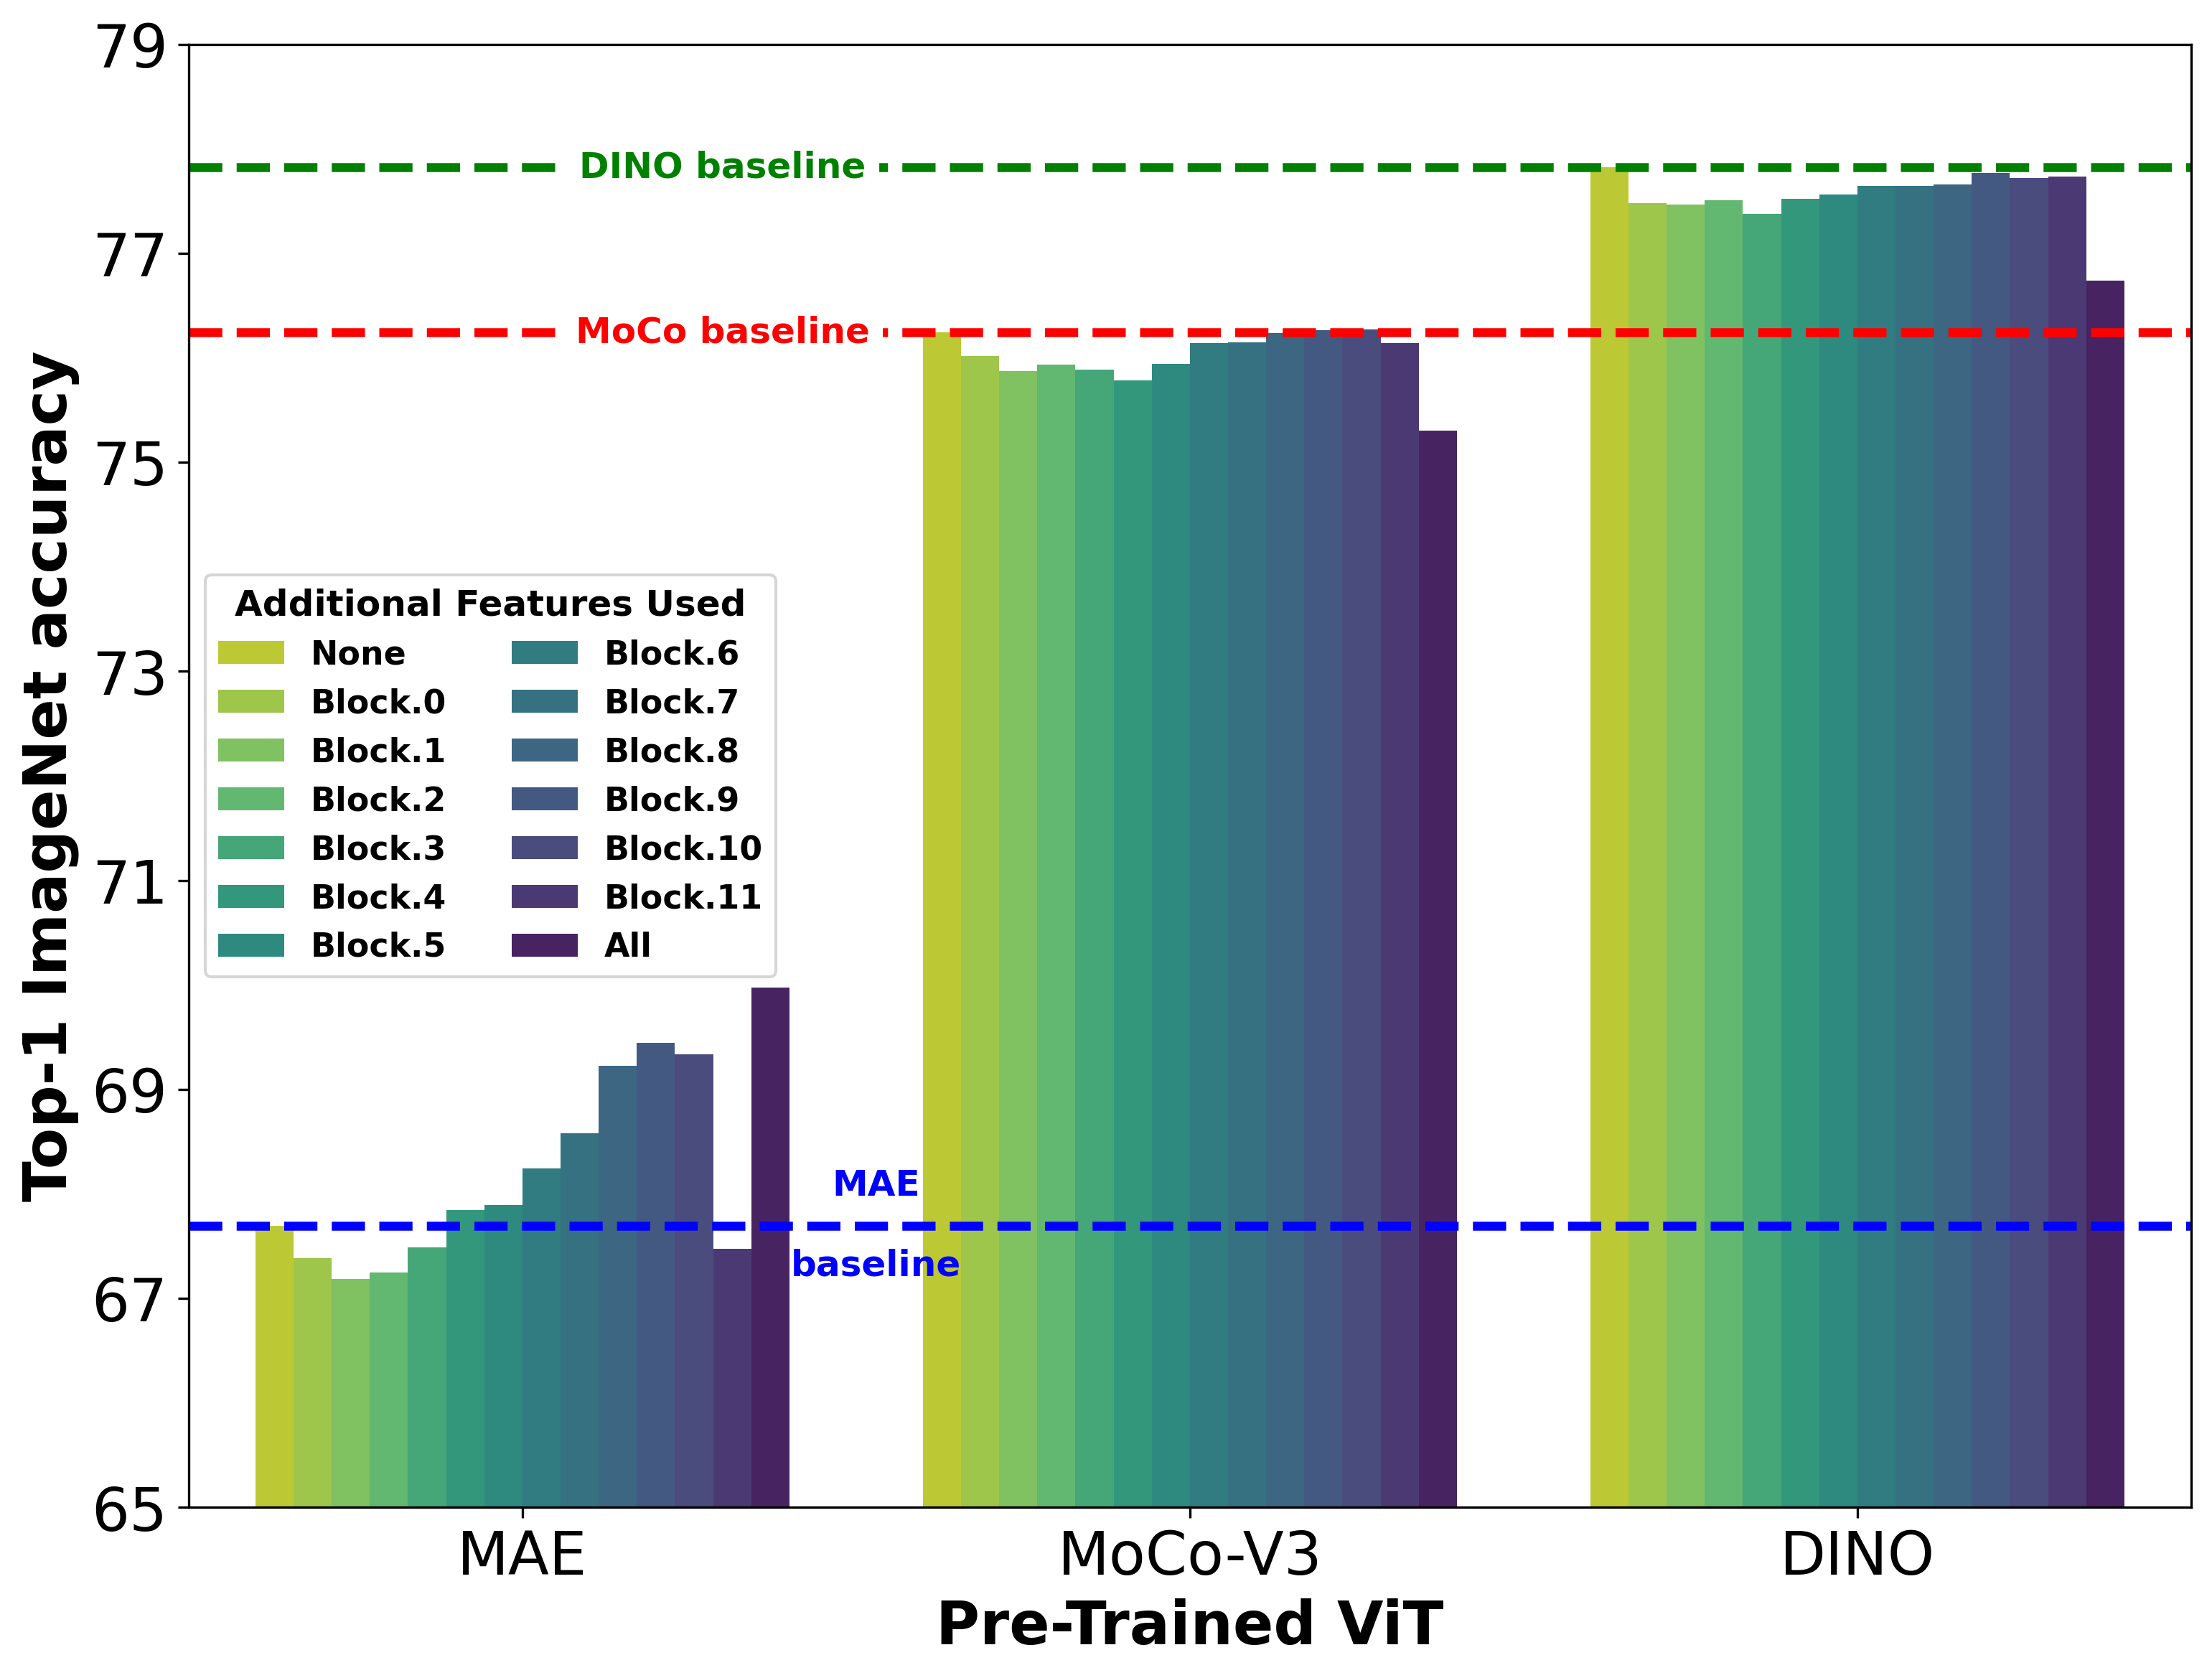

In [16]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

plot = sns.barplot(data=df, x='Model', y='Top-1', hue='Intermediate Features', palette=reversed(sns.color_palette("viridis", 14)))
print(plot)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.53, (df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), 'MAE\n\nbaseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.ylim([65, 79])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(65, 80, 2), visible=True)
ax.set_yticklabels([x for x in np.arange(65, 80, 2)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 11, 'weight':'bold'}, ncol=2)
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

## Fine-Tuned MAE

In [17]:
results['MAE_FT'] = {}

for key in ['MAE_FT']:
    for depth in range(12):
        for l1_reg in [0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/blocks.' + str(depth) +'/l1_reg/' + str(l1_reg)

            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                if root[len(folder_name):].count(os.sep) < 2:
                    for file in files:
                        if file == 'log.txt':
                            log_file = os.path.join(root, file)     
                        
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)
                    
            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            results[key][depth] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.0/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.0/l1_reg/0/1713241/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.1/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.1/l1_reg/0/1713243/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.2/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.2/l1_reg/0/1713245/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.3/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.3/l1_reg/0/1713247/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.4/

In [18]:
for key in ['MAE_FT']:
        for l1_reg in [0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/all/l1_reg/' +str(l1_reg)
            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                if root[len(folder_name):].count(os.sep) < 2:
                    for file in files:
                        if file == 'log.txt':
                            log_file = os.path.join(root, file)     
                        
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)

            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            results[key]['all'] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/all/l1_reg/0/2397462/log.txt


In [28]:
df= {}
for key in ['MAE', 'MAE_FT']:
    df[key] = {}
    for k in results[key]:
        if k=='all':
            df[key]['All'] = results[key][k]['test_acc1'].max()
        else:
            df[key]['Block.'+str(k)] = results[key][k]['test_acc1'].max()

In [29]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Intermediate Features'}, inplace=True)
df = df.melt(id_vars=['Intermediate Features'], value_name='Top-1', var_name='Model')

AxesSubplot(0.125,0.125;0.775x0.755)


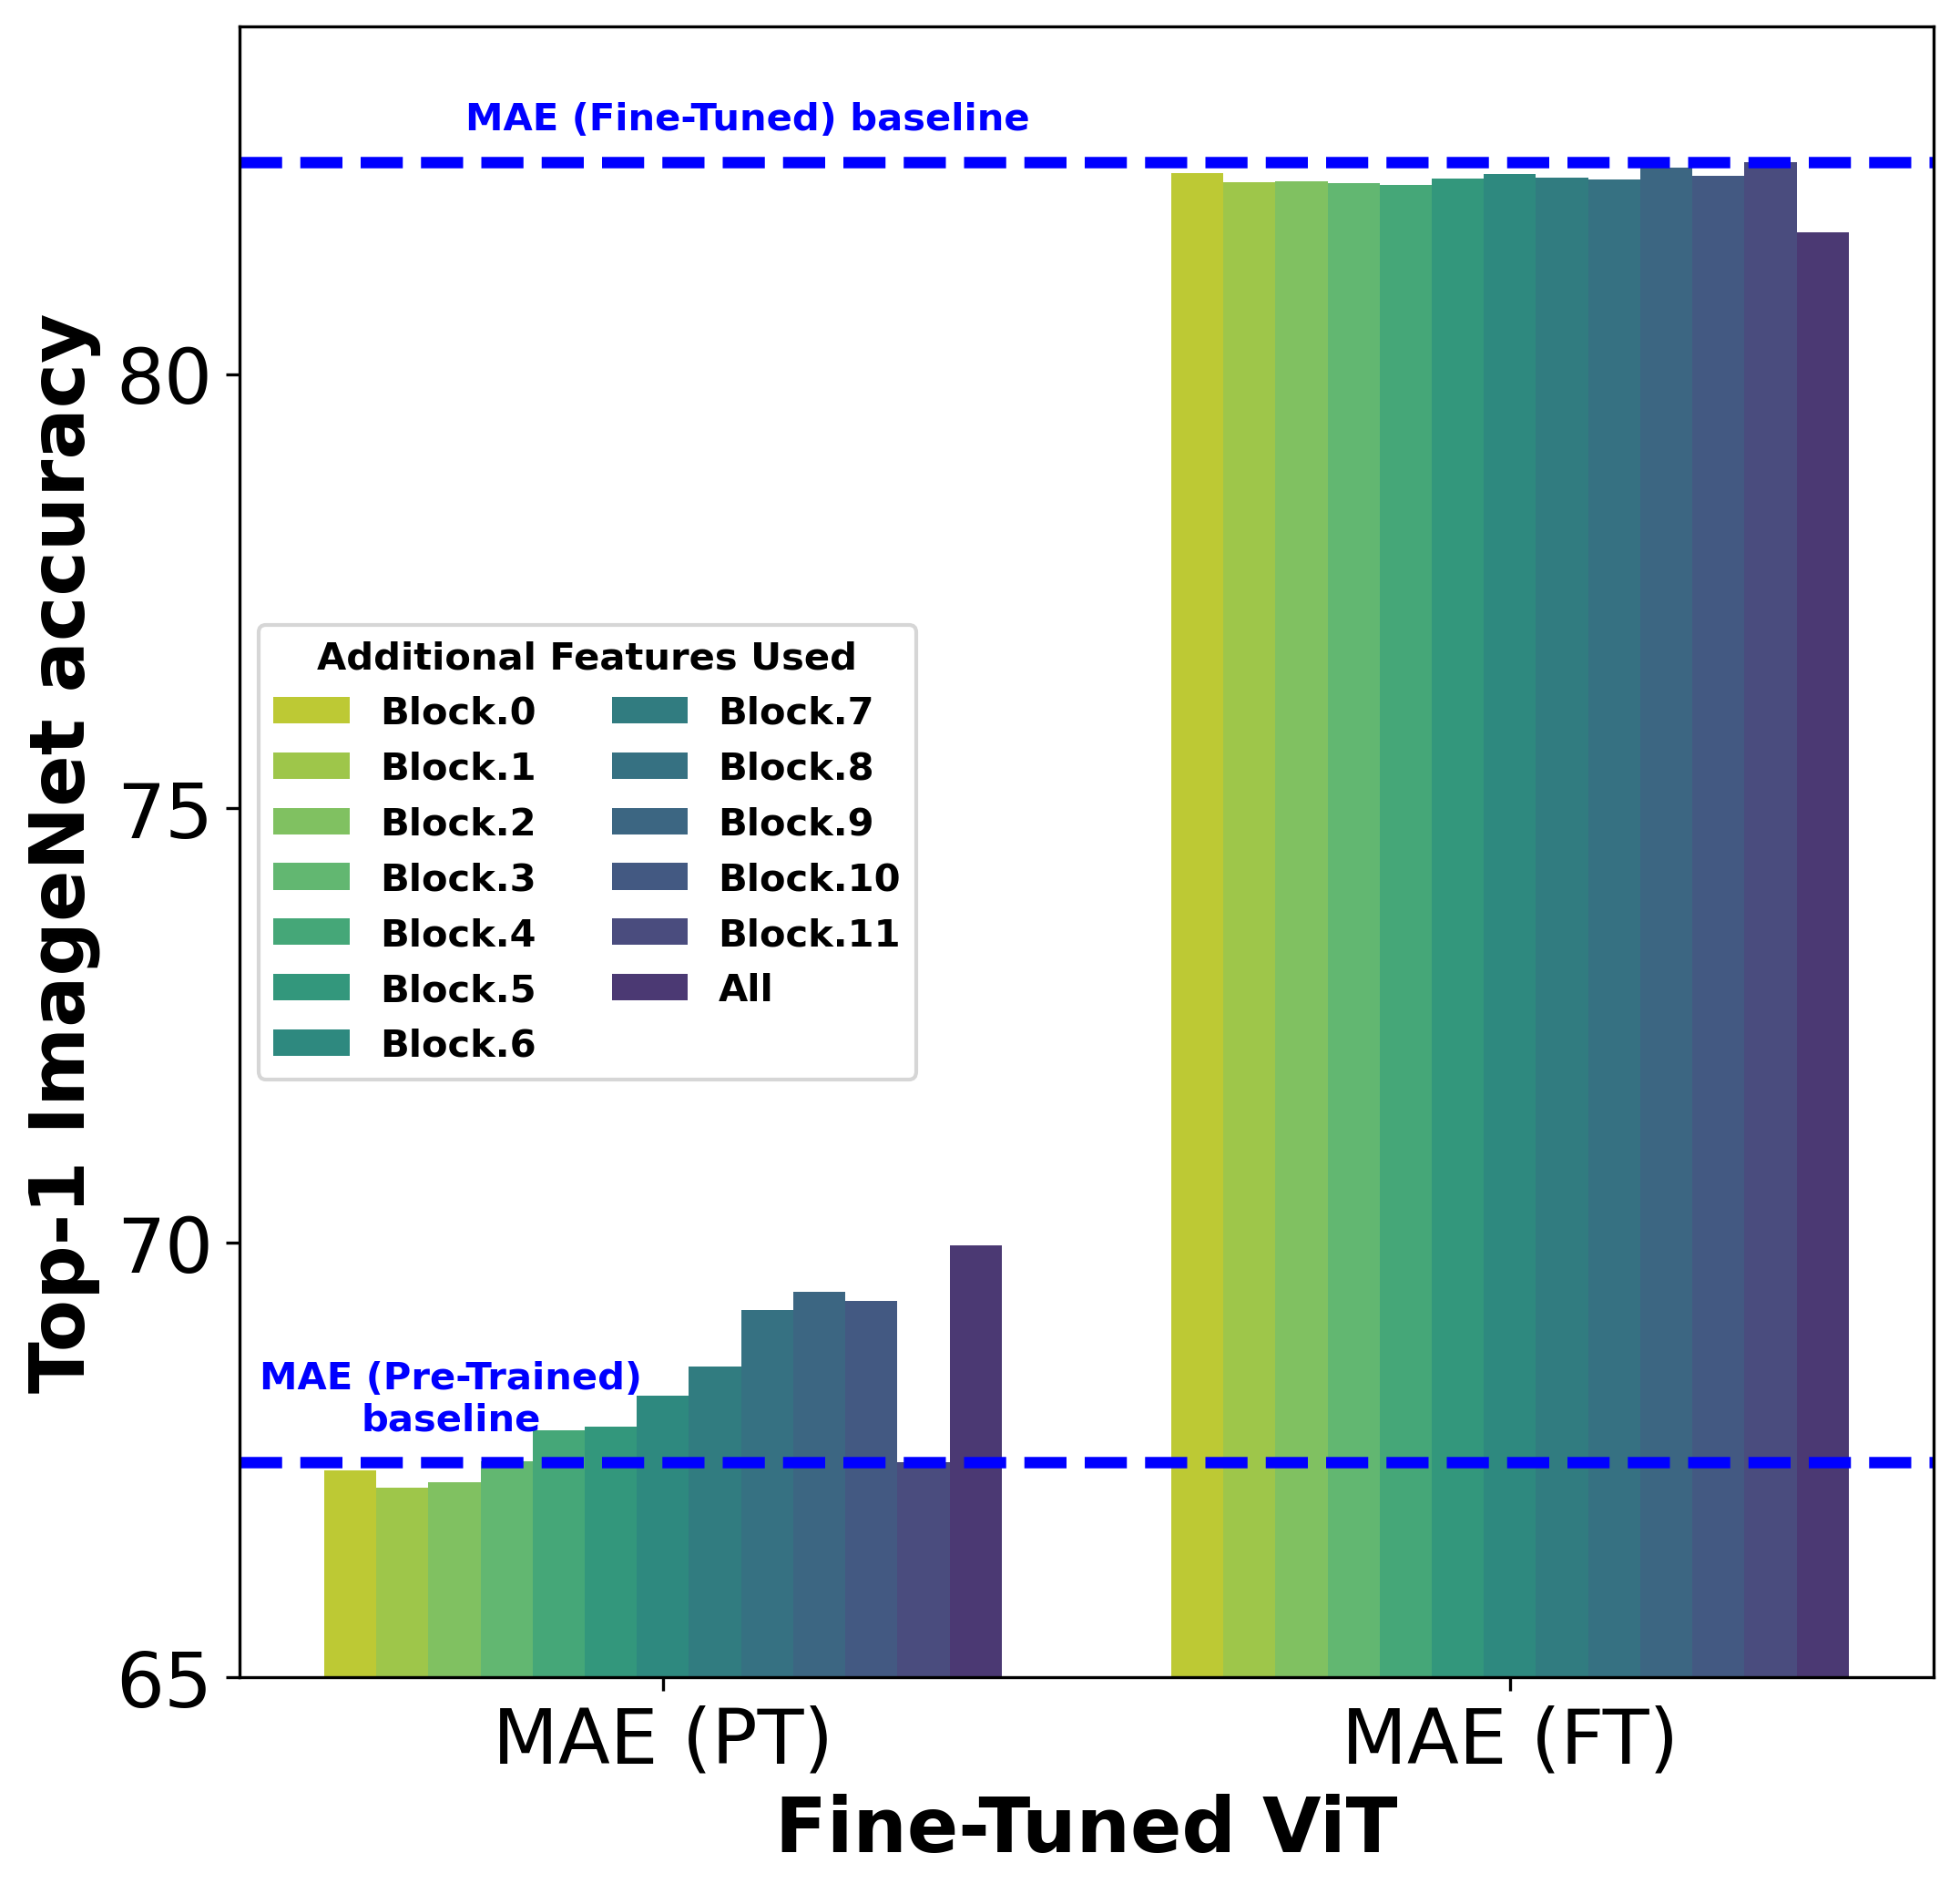

In [37]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300, sharex=True)

plot = sns.barplot(data=df, x='Model', y='Top-1', hue='Intermediate Features', palette=reversed(sns.color_palette("viridis", 14)))
print(plot)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'Block.11')]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(-0.25, (df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'Block.11')]['Top-1'].values[0]), 'MAE (Pre-Trained)\nbaseline\n\n\n', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MAE_FT') & (df['Intermediate Features'] == 'Block.11')]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.1, (df[(df['Model'] == 'MAE_FT') & (df['Intermediate Features'] == 'Block.11')]['Top-1'].values[0]), 'MAE (Fine-Tuned) baseline\n\n', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')

ax.set_xlabel("Fine-Tuned ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.ylim([65, 84])

ax.set_xticklabels(['MAE (PT)', 'MAE (FT)'], fontsize = 20)
ax.set_yticks(np.arange(65, 85, 5), visible=True)
ax.set_yticklabels([x for x in np.arange(65, 85, 5)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 10, 'weight':'bold'}, ncol=2)
plt.setp(legend.get_title(),fontsize=10, fontweight='bold')

#ax.legend(title="Additional\nFeat. Used", prop={'size': 10}, bbox_to_anchor=(1.05, .75))
#plt.setp(legend.get_title(),fontsize=10)

fig.savefig(fig_dir + 'mae_ft_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Detection & Segmentation

In [22]:
resultsint = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsint:

    folder_name = "/checkpoint/sshkhr/experiments/detectron/" + key.lower() + '-pt/output/'
    log_file = folder_name + "metrics.json"
        
    log_list = []
    print(log_file)
    if os.path.isfile(log_file):
        with open(log_file, "r") as log:
            for line in log:
                log_dict = literal_eval(line)
                if "bbox/AP" in log_dict.keys():
                    log_list.append(log_dict)
    
    df = pd.DataFrame(log_list)
    df = df.set_index('iteration')
    resultsint[key]['None'] = df
                    
    for i in range(9,12):
        folder_name = "/checkpoint/sshkhr/experiments/detectron/multi/" + key.lower() + '-pt/block'+str(i)+'-block11/output/'
        log_file = folder_name + "metrics.json"
            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file):
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    if "bbox/AP" in log_dict.keys():
                        log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('iteration')
        resultsint[key][i] = df

/checkpoint/sshkhr/experiments/detectron/mae-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/mae-pt/block11-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/moco-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/moco-pt/block11-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/dino-pt/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block9-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block10-block11/output/metrics.json
/checkpoint/sshkhr/experiments/detectron/multi/dino-pt/block11-block11/o

In [23]:
df= {}
for key in resultsint:
    df[key] = {}
    for k in resultsint[key]:
        if k=='None':
            df[key]['None'] = resultsint[key][k]['bbox/AP'].max()
        else:
            df[key]['Block.'+str(k)] = resultsint[key][k]['bbox/AP'].max()

In [24]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Intermediate Features'}, inplace=True)
df = df.melt(id_vars=['Intermediate Features'], value_name='bbox/AP', var_name='Model')

In [25]:
df

,Intermediate Features,Model,bbox/AP
0,None,MAE,30.277264
1,Block.9,MAE,31.460068
2,Block.10,MAE,31.714337
3,Block.11,MAE,30.469100
4,None,MoCo,28.750739
5,Block.9,MoCo,29.960781
6,Block.10,MoCo,20.324329
7,Block.11,MoCo,28.921014
8,None,DINO,32.568707
9,Block.9,DINO,33.475884


In [26]:
df.loc[((df.Model=='MoCo') & (df['Intermediate Features']=='Block.10')), ['bbox/AP']] = 29.324329

AxesSubplot(0.125,0.125;0.775x0.755)


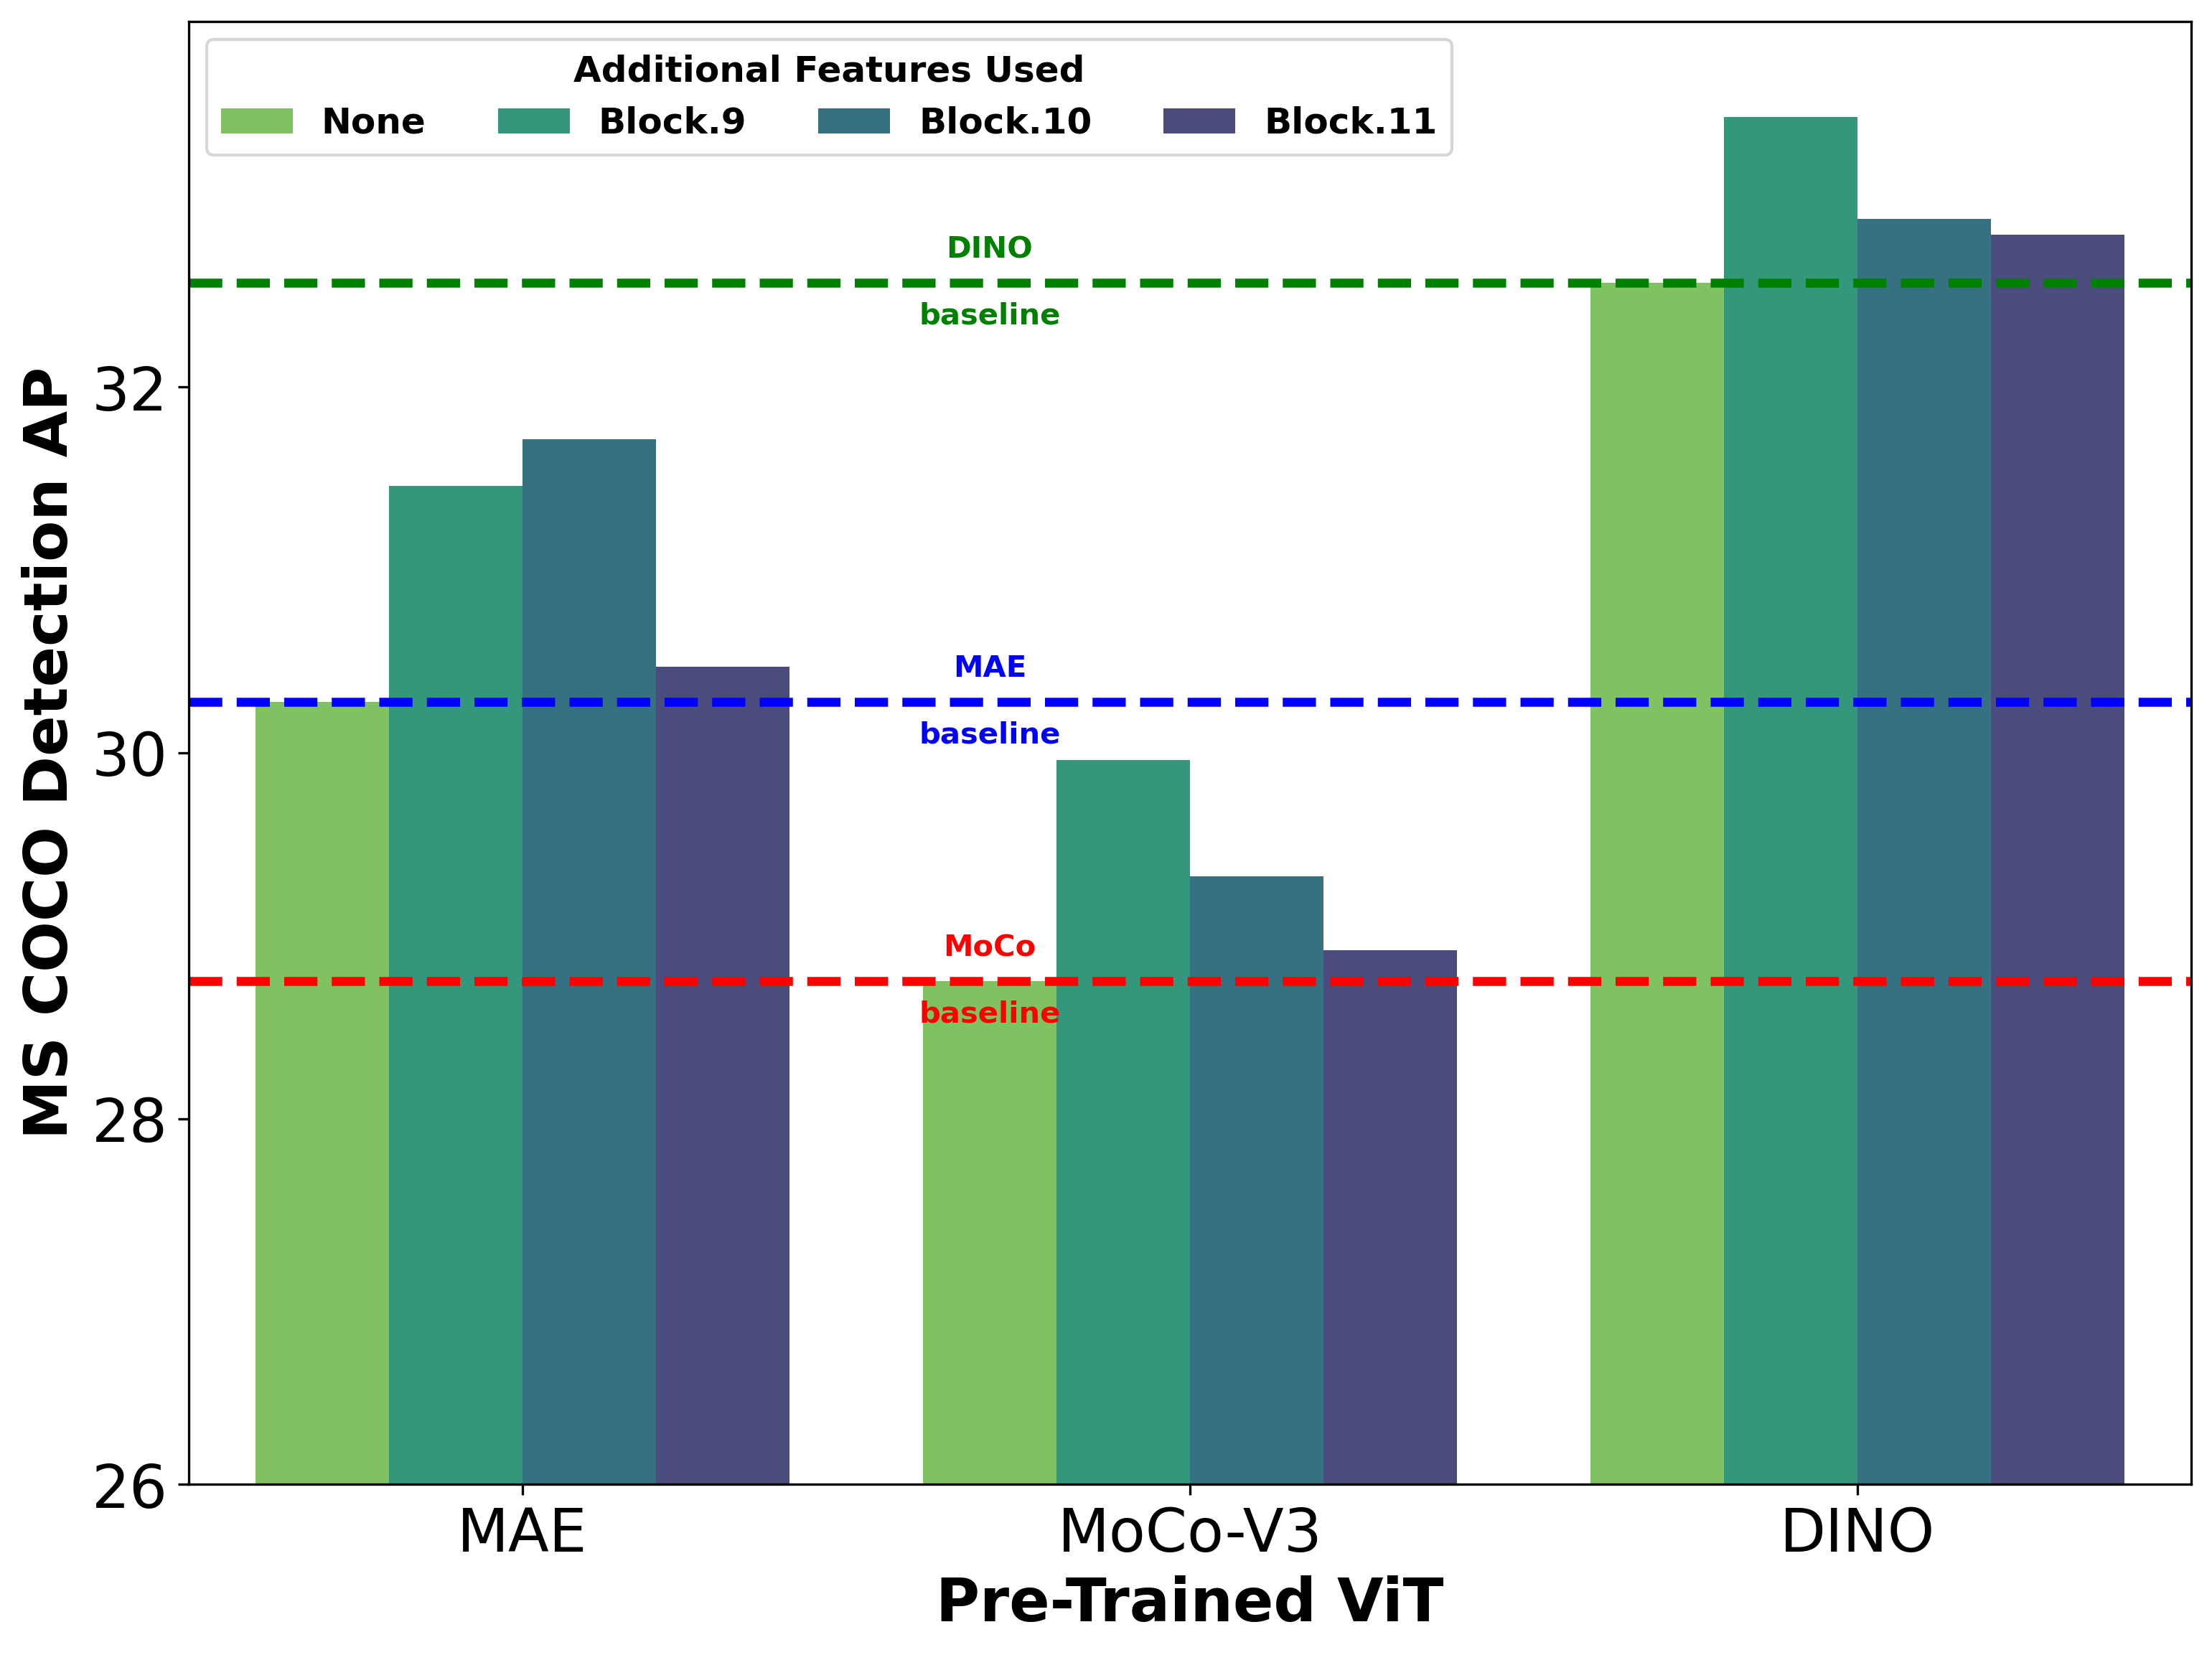

In [27]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

plot = sns.barplot(data=df, x='Model', y='bbox/AP', hue='Intermediate Features', palette=reversed(sns.color_palette("viridis", 4)))
print(plot)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'MAE') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'MAE\n\nbaseline', fontsize=10, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'MoCo') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'MoCo\n\nbaseline', fontsize=10, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.7, (df[(df['Model'] == 'DINO') & (df['Intermediate Features'] == 'None')]['bbox/AP'].values[0]), 'DINO\n\nbaseline', fontsize=10, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='none')

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("MS COCO Detection AP", fontweight="bold", fontsize = 20)

plt.ylim([26, 34])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(26, 34, 2), visible=True)
ax.set_yticklabels([x for x in np.arange(26, 34, 2)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 12, 'weight':'bold'}, ncol=4)
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'coco_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 